<a href="https://colab.research.google.com/github/tatsubo777/Kaggle_Signate_competition/blob/master/jpx_Tokyo_stack_scoring_lightgbm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from IPython.display import Image

# コンテストの概要
* 日本取引所グループ（JPX）による、2000銘柄の証券を対象にした、**証券の値段（終値）の変化率**予測。
* **翌日から翌々日にかけての終値**の変化率が目的変数。
* 提出データは、目的変数の値そのものではなく、目的変数の値を降順に並べた際の順位。
* コンテストについて、より詳しく知りたい場合は[【日本語ver】Easy to understand the competition](https://www.kaggle.com/code/chumajin/ver-easy-to-understand-the-competition)が非常に役に立つと思います。

# ノートブックの概要
* このノートブックでは[データ読み込み]→[データ統合]→[特徴量エンジニアリング]→[学習]→[推論・評価]→[提出]を一気通貫で行います。
* 使用するモデルはLightGBMです。
* モデルを3つ生成し、結果をアンサンブルして最終的な推論結果を作成します。

推論・評価までの流れは以下の通りです。  
赤背景は推論・評価推時のみ使用している関数です。青背景は提出時にも使用している関数・データとなります。  
青背景の関数をカスタマイズすることで、様々な特徴量で精度検証ができ、また、そのままSubmitもできるようになっています。

In [13]:
Image('../input/jpx-images/jpx_flow.drawio.png')

# 入力ファイルの概要
* `jpx-tokyo-stock-exchange-prediction/`
    * `stock_list.csv`:  主な項目は証券コードと証券に関する属性情報。Keyは**SecuritiesCode**。
    * `train_files/`:  学習用データ群。Dateの範囲は2017-01-04 ～ 2021-12-03。
        * `stock_prices.csv`:  主な項目は証券コードと日単位の証券価格、および、目的変数（Target）。Keyは**Date**と**SecuritiesCode**であり、これらを連結した**RowId**も用意されている。
        * `secondary_stock_prices.csv`:  項目は**stock_prices.csv**と同じだが、**stock_prices.csv**の対象とならなかった証券が入っている。Keyは**stock_prices.csv**と同じ。
        * `options.csv`:  主な項目はオプション（証券用語）コードと日単位のオプション価格。Keyは**Date**と**OptionsCode**であり、これらを連結した**DateCode**も用意されている。
        * `trades.csv`:  主な項目はマーケット毎の前営業週における取引サマリ。Keyは**Date**と**Section**。**Section**を加工することで**stock_list.csv**の**NewMarketSegment**と紐づけることができる。意味のあるレコードの発生は週次。
        * `financials.csv`:  主な項目は四半期決算報告の内容。Keyは**Date**と**SecuritiesCode**であり、これらを連結した**DateCode**も用意されている。レコードの発生は四半期毎。
    * `supplemental_files/`:  追加の学習用データ群。5月上旬、6月上旬、およびコンテスト終了直前に最新のデータが反映される。2022-04-05時点でのDateの範囲は2021-12-06 ～ 2022-02-28。
        * **train_files**配下と同じ形式のファイル群が格納されている
        * `example_test_files/`:  評価用データ群（のサンプル）
        * **train_files**配下とほぼ（※）同じ形式のファイル群が格納されている
        * ※ **stock_prices.csv**と**secondary_stock_prices.csv**から**Target**が削除されている点だけが**train_files**配下と異なる
    * `data_specifications/`:  上記ファイル群の項目説明書
        * `stock_list_spec.csv`:  **stock_list.csv**の項目説明書
        * `stock_prices_spec.csv`:  **stock_prices.csv**、**secondary_stock_prices.csv**の項目説明書
        * `options_spec.csv`:  **options.csv**の項目説明書
        * `trades_spec.csv`:  **trades.csv**の項目説明書
        * `stock_fin_spec.csv`:  **financials.csv**の項目説明書
    * `jpx_tokyo_market_prediction/`:時系列API
    
ファイル間の関係性は以下のようなイメージです

In [14]:
Image('../input/jpx-images/jpx_files.drawio.png')

データの詳細は https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data を参照  
時系列APIの使い方は https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview/evaluation を参照  
オプションコード体系の日本語版は https://www.jpx.co.jp/sicc/securities-code/nlsgeu0000032d48-att/(HP)sakimono20220208.pdf を参照  
証券コード関係は https://www.jpx.co.jp/sicc/securities-code/01.html を参照

# 準備
* 使用するライブラリをインポートします

In [15]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [16]:
!pip install kaggle

In [17]:
!chmod 600 /root/.kaggle/kaggle.json

In [18]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [19]:
!kaggle competitions download -c jpx-tokyo-stock-exchange-prediction

jpx-tokyo-stock-exchange-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
!unzip jpx-tokyo-stock-exchange-prediction.zip

Archive:  jpx-tokyo-stock-exchange-prediction.zip
replace data_specifications/options_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_specifications/options_spec.csv  
replace data_specifications/stock_fin_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_specifications/stock_fin_spec.csv  
replace data_specifications/stock_list_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_specifications/stock_list_spec.csv  
replace data_specifications/stock_price_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_specifications/stock_price_spec.csv  
replace data_specifications/trades_spec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_specifications/trades_spec.csv  
replace example_test_files/financials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: example_test_files/financials.csv  
replace example_test_files/options.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: example_test_files/

# データ読み込み

以下のファイル群を読み込みます。
* stock_list.csv
* train_files 配下のファイル（Dateの範囲は2017-01-04 ～ 2021-12-03）
* supplemental_files 配下のファイル（Dateの範囲は2021-12-06 ～ 2022-02-28 ※2022/04/05現在）

## Function

In [21]:
def read_files(dir_name: str = 'train_files'):
  base_path = Path(f'/content/{dir_name}')
  prices = pd.read_csv(base_path / 'stock_prices.csv')
  options = pd.read_csv(base_path /'options.csv')
  financials = pd.read_csv(base_path/'financials.csv')
  trades = pd.read_csv(base_path/ 'trades.csv')
  secondary_prices = (base_path / 'secondary_stock_prices.csv')
  return prices,options,financials,trades,secondary_prices

## Exec

In [22]:
%%time

stock_list = pd.read_csv('/content/stock_list.csv')
train_files = read_files('train_files')
supplemental_files = read_files('supplemental_files')

CPU times: user 16.7 s, sys: 2.43 s, total: 19.1 s
Wall time: 19.3 s


# データ統合

* 読み込んだデータを結合して、一つのファイルに纏めます。

## Function

`merge_data`関数では各ファイルを水平方向に結合します。現時点では`stock_prices`、`stock_list`しか使っていません。  
コメントアウトを解除すれば`trades`、`financials`とも結合は可能ですが、  
これらのデータは、有効なレコードが発生するタイミングが日次ではないため、学習データとして意味のあるものとするためには「直近に発生した有効なレコードの値を引き継ぐ」などの対処が必要となります。  
`options`に関しては、[OptionsCodeの附番規則](https://www.jpx.co.jp/sicc/securities-code/nlsgeu0000032d48-att/(HP)sakimono20220208.pdf)を見ていけば適切な使い方が見えそうです。

In [23]:
def merge_data(prices, options, financials, trades, secondary_prices, stock_list):
    # stock_prices がベース
    base_df = prices.copy()
    
    # stock_listと結合
    _stock_list = stock_list.copy()
    _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
    base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")

    # tradesと結合
    # stock_listのNewMarketSegmentと紐づくよう、tradesのSection項目を編集する
    # _trades = trades.copy()
    # _trades['NewMarketSegment'] = _trades['Section'].str.split(' \(', expand=True)[0]
    # base_df = base_df.merge(_trades, on=['Date', 'NewMarketSegment'], how="left")

    # financialsと結合
    # _financials = financials.copy()
    # _financials.rename(columns={'Date': 'Date_x', 'SecuritiesCode': 'SecuritiesCode_x'}, inplace=True)
    # base_df = base_df.merge(_financials, left_on='RowId', right_on='DateCode', how="left")
    
    return base_df

`adjust_price`関数は[Train Demo](https://www.kaggle.com/code/smeitoma/train-demo)で紹介されている関数をほぼそのまま使わせて頂いています。（Dateのインデックス化だけコメントアウトしています）  
項目追加が発生するため、統合の範囲を超えていますが、関数内でソートやインデックスの生成といった操作が行われるため、この段階で実行しています。  
  
関数では**AdjustedClose**という項目が生成されます。  
株式は、分割や併合によって株価が大きく変動することがありますが、**Close**の代わりに**AdjustedClose**を使うことで、この影響を減少させることができるとのことです。

In [24]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

In [25]:
def collector(prices, options, financials, trades, secondary_prices, stock_list):
    # 読み込んだデータを統合して一つのファイルに纏める
    base_df = merge_data(prices, options, financials, trades, secondary_prices, stock_list)
    # AdjustedClose項目の生成
    base_df = adjust_price(base_df)
    
    return base_df

## Exec

supplemental filesを使わない場合は4行目以降をコメントアウトします。

In [26]:
%%time

base_df = collector(*train_files, stock_list)
supplemental_df = collector(*supplemental_files, stock_list)
base_df = pd.concat([base_df, supplemental_df]).reset_index(drop=True)

CPU times: user 32.3 s, sys: 819 ms, total: 33.1 s
Wall time: 33 s


# 特徴量エンジニアリング

特徴量を生成し、推論結果の精度向上に貢献するものだけを選びます。  

## Function

`calc_change_rate_base`関数と`calc_volatility_base`関数は、[Train Demo](https://www.kaggle.com/code/smeitoma/train-demo)で紹介されていた関数を参考にしています。

In [27]:
# 「column_name で指定された項目の、periodsで指定された期間（複数）での変化率を導出し、項目として追加する関数」を生成する関数
# 生成された関数は、特定証券コードだけを持つデータフレームが入力されることを前提としている。
def calc_change_rate_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_change_rate_{period}"] = price[column_name].pct_change(period)
        return price
    return func


# 「column_name で指定された項目の、periodsで指定された期間（複数）での変動の度合いを導出し、項目として追加する関数」を生成する関数
# 生成された関数は、特定証券コードだけを持つデータフレームが入力されることを前提としている。
def calc_volatility_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_volatility_{period}"] = np.log(price[column_name]).diff().rolling(window=period, min_periods=1).std()
        return price
    return func

# 「column_name で指定された項目の、periodsで指定された期間（複数）での移動平均値と現在値の比率を導出し、項目として追加する関数」を生成する関数
# 移動平均値そのものではなく、現在値に対する比率としているのは、今回のTargetが比率であるため。
# 生成された関数は、特定証券コードだけを持つデータフレームが入力されることを前提としている。
def calc_moving_average_rate_base(column_name, periods):
    def func(price):
        for period in periods:
            price.loc[:, f"{column_name}_average_rate_{period}"] = price[column_name].rolling(window=period, min_periods=1).mean() / price[column_name]
        return price
    return func

# 終値の変動率を生成し、項目として追加する関数。これをShift-2するとTargetになる。
# この関数は、特定証券コードだけを持つデータフレームが入力されることを前提としている。
def calc_target_shift2(price):
    price.loc[:, 'Target_shift2'] = price['Close'].pct_change()
    return price

# 入力データフレームを証券コード毎にグルーピングし、引数で渡された関数を適用する関数
# functionsには↑で定義したcalc_xxxの関数のリストが渡される想定。
def add_columns_per_code(price, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(func)
    price = price.reset_index(drop=True)
    return price

# 入力データフレームに特徴量を追加する関数
# 追加する項目は、基本的にレコード内の値だけを使う想定
def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

# 入力データフレームに特徴量を追加する関数
def generate_features(base_df):
    prev_column_names = base_df.columns
    
    periods = [3, 9]
    functions = [
        calc_change_rate_base("AdjustedClose", periods), 
        calc_volatility_base("AdjustedClose", periods), 
        calc_moving_average_rate_base("Volume", periods), 
        calc_target_shift2
    ]
    
    # 証券コード単位の特徴量（移動平均等、一定期間のレコードをインプットに生成する特徴量）を追加
    base_df = add_columns_per_code(base_df, functions)
    # 日単位の特徴量（レコード内の値で導出できる特徴量）を追加
    base_df = add_columns_per_day(base_df)
    
    # 後で特徴量を選択しやすくするため、追加した項目名のリストを生成
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    return base_df, add_column_names

In [28]:
# 特徴量選択
def select_features(feature_df, add_column_names, is_train):
    # 基本項目
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    # 数値系の特徴量
    numerical_cols = sorted(add_column_names)
    # カテゴリ系の特徴量
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    # 目的変数
    label_col = ['Target']
    
    # 特徴量
    feat_cols = numerical_cols + categorical_cols

    # データフレームの項目を選択された項目だけに絞込
    feature_df = feature_df[base_cols + feat_cols + label_col]
    # カテゴリ系項目はdtypeをcategoryに変更
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')

    if is_train:
        # 学習データの場合は、NA項目があるレコードを削除
        feature_df.dropna(inplace=True)
    else:
        # 推論データの場合は、NA項目を補完
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    
    return feature_df, feat_cols, label_col

In [29]:
def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## 特徴量生成
    feature_df, add_column_names = generate_features(feature_df)
    
    ## 特徴量選択
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    return feature_df, feat_cols, label_col

## Exec

In [30]:
%%time

feature_df, feat_cols, label_col = preprocessor(base_df)

CPU times: user 23.8 s, sys: 1.08 s, total: 24.9 s
Wall time: 24.8 s


# 学習

## Function

学習を行いモデルを生成します

In [31]:
# 予測値を降順に並べて順位番号を振る関数
# 言い換えると、目的変数から提出用項目を導出する関数
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

`calc_spread_return_sharpe`関数は[Train Demo](https://www.kaggle.com/code/smeitoma/train-demo)で紹介されている関数をそのまま使わせて頂いています。  
推論した**Rank**と、正解の**Target**を含むデータフレームを渡すと、コンテストの評価方法に沿ったスコアを計算してくれます。

In [32]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [33]:
# 予測用のデータフレームと、予測結果をもとに、スコアを計算する関数
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

`lightgbm`ではなく`optuna.integration.lightgbm`をimportすることで、パイパーパラメータチューニングが実行されるようになります。

In [34]:
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb

# 学習を実行する関数
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022):
    scores = []
    models = []
    params = []

    for param in fold_params:
        ################################
        # データ準備
        ################################
        train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
        valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

        X_train = train[feat_cols]
        y_train = train[label_col]
        X_valid = valid[feat_cols]
        y_valid = valid[label_col]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        ################################
        # 学習
        ################################
        params = {
            'task': 'train',                   # 学習
            'boosting_type': 'gbdt',           # GBDT
            'objective': 'regression',         # 回帰
            'metric': 'rmse',                  # 損失（誤差）
            'learning_rate': 0.01,             # 学習率
            'lambda_l1': 0.5,                  # L1正則化項の係数
            'lambda_l2': 0.5,                  # L2正則化項の係数
            'num_leaves': 10,                  # 最大葉枚数
            'feature_fraction': 0.5,           # ランダムに抽出される列の割合
            'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
            'bagging_freq': 5,                 # バギング実施頻度
            'min_child_samples': 10,           # 葉に含まれる最小データ数
            'seed': seed                       # シード値
        } 
 
        lgb_results = {}                       
        model = lgb.train( 
            params,                            # ハイパーパラメータ
            lgb_train,                         # 訓練データ
            valid_sets=[lgb_train, lgb_valid], # 検証データ
            valid_names=['Train', 'Valid'],    # データセット名前
            num_boost_round=2000,              # 計算回数
            early_stopping_rounds=100,         # 計算打ち切り設定
            evals_result=lgb_results,          # 学習の履歴
            verbose_eval=100,                  # 学習過程の表示サイクル
        )  

        ################################
        # 結果描画
        ################################
        fig = plt.figure(figsize=(10, 4))

        # loss
        plt.subplot(1,2,1)
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Valid']['rmse']   
        plt.xlabel('Iteration')
        plt.ylabel('logloss')
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='valid loss')
        plt.legend()

        # feature importance
        plt.subplot(1,2,2)
        importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
        sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

        plt.tight_layout()
        plt.show()

        ################################
        # 評価
        ################################
        # 推論
        pred =  model.predict(X_valid, num_iteration=model.best_iteration)
        # 評価
        score = evaluator(valid, pred)

        scores.append(score)
        models.append(model)

    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

## Exec

Training until validation scores don't improve for 100 rounds.
[100]	Train's rmse: 0.0215084	Valid's rmse: 0.0246446
[200]	Train's rmse: 0.0214951	Valid's rmse: 0.0246444
Early stopping, best iteration is:
[165]	Train's rmse: 0.0214991	Valid's rmse: 0.0246428


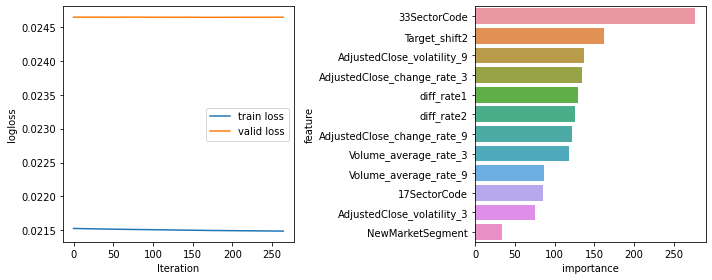

Training until validation scores don't improve for 100 rounds.
[100]	Train's rmse: 0.0218368	Valid's rmse: 0.0222499
[200]	Train's rmse: 0.0218226	Valid's rmse: 0.0222364
[300]	Train's rmse: 0.0218121	Valid's rmse: 0.0222282
[400]	Train's rmse: 0.0218032	Valid's rmse: 0.0222191
[500]	Train's rmse: 0.0217949	Valid's rmse: 0.0222179
Early stopping, best iteration is:
[475]	Train's rmse: 0.0217968	Valid's rmse: 0.0222164


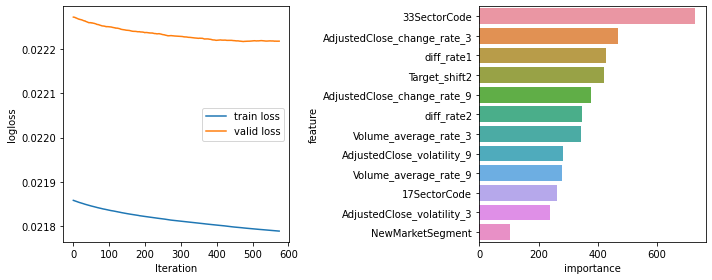

Training until validation scores don't improve for 100 rounds.
[100]	Train's rmse: 0.0215521	Valid's rmse: 0.0251059
[200]	Train's rmse: 0.0215305	Valid's rmse: 0.0250856
[300]	Train's rmse: 0.0215165	Valid's rmse: 0.0250726
[400]	Train's rmse: 0.0215052	Valid's rmse: 0.0250651
[500]	Train's rmse: 0.0214957	Valid's rmse: 0.025057
[600]	Train's rmse: 0.0214873	Valid's rmse: 0.0250544
[700]	Train's rmse: 0.0214794	Valid's rmse: 0.0250546
[800]	Train's rmse: 0.0214719	Valid's rmse: 0.0250516
[900]	Train's rmse: 0.0214656	Valid's rmse: 0.0250475
[1000]	Train's rmse: 0.0214593	Valid's rmse: 0.0250473
[1100]	Train's rmse: 0.021453	Valid's rmse: 0.0250451
[1200]	Train's rmse: 0.0214469	Valid's rmse: 0.0250436
[1300]	Train's rmse: 0.021441	Valid's rmse: 0.0250419
[1400]	Train's rmse: 0.0214353	Valid's rmse: 0.0250417
[1500]	Train's rmse: 0.02143	Valid's rmse: 0.0250385
[1600]	Train's rmse: 0.0214251	Valid's rmse: 0.0250393
Early stopping, best iteration is:
[1560]	Train's rmse: 0.0214269	Valid

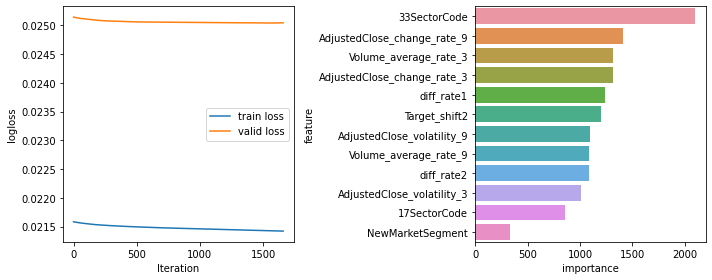

CV_SCORES: [0.29534986094732585, 0.31011734257423873, 0.22807403427257397]
CV_SCORE: 0.27784707926471286


In [35]:
# 2020-12-23よりも前のデータは証券コードが2000個すべて揃っていないため、これ以降のデータのみを使う。
# (学習用データの開始日、学習用データの終了日＝検証用データの開始日、検証用データの終了日)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params)

# 推論・評価

生成したモデルを使って試験用データの推論を行いスコアを算出します。

## Function

In [36]:
def predictor(feature_df, feat_cols, models, is_train=True):
    X = feature_df[feat_cols]
    
    # 推論
    preds = list(map(lambda model: model.predict(X, num_iteration=model.best_iteration), models))
    
    # スコアは学習時のみ計算
    if is_train:
        scores = list(map(lambda pred: evaluator(feature_df, pred), preds))
        print("SCORES:", scores)

    # 推論結果をバギング
    pred = np.array(preds).mean(axis=0)

    # スコアは学習時のみ計算
    if is_train:
        score = evaluator(feature_df, pred)
        print("SCORE:", score)
    
    return pred

## Exec

In [37]:
# 試験用データは学習用にも検証用にも使用していないものを使う
test_df = feature_df[('2022-02-01' <= feature_df['Date'])].copy()
pred = predictor(test_df, feat_cols, models)

SCORES: [-0.06262645643201462, -0.11132825915561868, -0.09400916992129663]
SCORE: -0.10668912528370172


# 提出

時系列APIを使って推論結果を登録します。  
特徴量として、移動平均等の過去データを参照する値を採用しているため、時系列APIから得られたデータをため込む仕組みを実装する必要があります。  
この仕組みに関しては、[Start-to-finish demo based on s-meitoma + tweaks](https://www.kaggle.com/code/lowellniles/start-to-finish-demo-based-on-s-meitoma-tweaks)を参考にさせていただきました。  
以下のコードでは`past_df`というデータフレームに履歴データをため込む実装になっています。

In [38]:
# 時系列APIのロード
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [39]:
# supplemental filesを履歴データの初期状態としてセットアップ
past_df = supplemental_df.copy()

In [40]:
# 日次で推論・登録
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
    current_date = prices["Date"].iloc[0]

    if i == 0:
        # リークを防止するため、時系列APIから受け取ったデータより未来のデータを削除
        past_df = past_df[past_df["Date"] < current_date]

    # リソース確保のため古い履歴を削除
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80)).strftime("%Y-%m-%d")
    past_df = past_df[past_df["Date"] >= threshold]
    
    # 時系列APIから受け取ったデータを履歴データに統合
    base_df = collector(prices, options, financials, trades, secondary_prices, stock_list)
    past_df = pd.concat([past_df, base_df]).reset_index(drop=True)

    # 特徴量エンジニアリング
    feature_df, feat_cols, label_col = preprocessor(past_df, False)

    # 予測対象レコードだけを抽出
    feature_df = feature_df[feature_df['Date'] == current_date]

    # 推論
    feature_df["pred"] = predictor(feature_df, feat_cols, models, False)

    # 推論結果からRANKを導出し、提出データに反映
    feature_df = add_rank(feature_df)
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    # 結果を登録
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
